In [10]:
import random                  
import math
import numpy as np
import copy
from matplotlib import pyplot as plt
from fractions import Fraction
from music21 import chord, corpus, environment, meter, midi, note, stream, tempo, converter

def play(stream):
    """Shortcut to play a stream"""
    midi.realtime.StreamPlayer(stream).play()

# Milestone 2

In this notebook we will outline our experimentation with various materials and sub-structures we plan to use for the final project.

## Note clouds

To describe the global movements of the species' populations, we thought it would be interesting to use sound masses (or note clouds).
We tried multiple approaches to creating these clouds, which we will describe in this section

### Various approaches

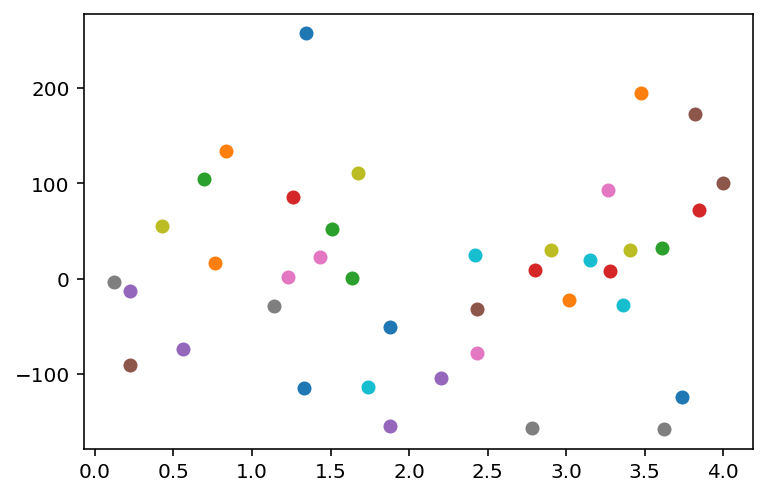

In [21]:
# Defining the number of points
n_points = 40

# We are taking here 4/4 as time signature. max_x = 4 allows to identify each integer to a beat
max_x = 4
mean = 0
dispersion = 100


def generate(n_points, max_x, mean, dispersion):
    """ Generate random points [0, max_x] x R using the given parameters"""
    points = []
    for i in range(n_points):
        x = random.uniform(0,x_up)
        y = random.gauss(mean, dispersion)
        points.append([x, y])
    for point in points:
        plt.scatter(point[0], point[1])
    
    return points

points = generate(n_points, max_x, mean, dispersion)

### Moving note clouds

Here we tried extending on our previous experimentation and creating clouds which change their register and "shape" through time. Furthermore we tried to use another method for generating the points, which is simply to add notes randomly for each beat.

In [11]:
# Determines the repertoire of notes that will be used in the cloud
# In this case we used a stack of fifths C, G, D, A, E
pitches = [x for x in range(1, 128) if (x % 12) in [0, 7, 2, 9, 4]]

In [12]:
def generate_cloud(position, width, intensity, start_time, end_time, step, pitches):
    """ Generates a cloud of notes given 3 functions, which determine the position,
        width and intensity of the cloud throughout time """
    m = stream.Measure()
    t = start_time
    while t <= end_time:
        notes = [] # Determines the pitches present in the chord
        pos = position(t)
        w = width(t)
        i = intensity(t)
        # Insert each pitch candidate, which is within the range with probability i
        for p in pitches:
            if p >= pos - w and p <= pos + w:
                if random.uniform(0, 1) <= i:
                    n = note.Note(pitch=p, quarterLength = step)
                    notes.append(n)
        # If chord would be empty, insert pause instead
        if len(notes) == 0:
            m.append(note.Rest(quarterLength = step))
        else:
            c = chord.Chord(notes)
            m.append(c)
        t += step
    return m

In [16]:
m = generate_cloud(lambda t: 60 + 12*math.sin(t), 
                   lambda t: 9 + 3*math.sin(t),
                   lambda t: 0.3, 0, 16, 0.0625, pitches)

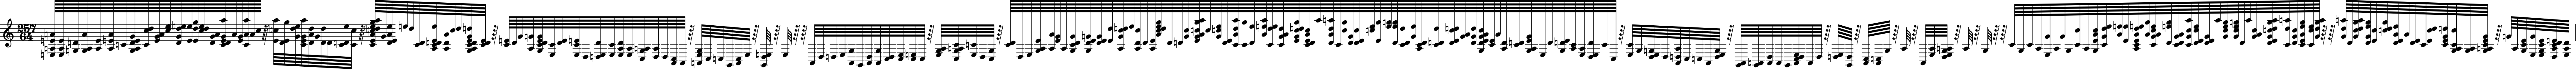

In [17]:
m.show()

In [18]:
play(m)

Through experimentation it seems a quick succession of notes works better, as with a very short interonset interval the notes seemingly blend together.

## Species' population simulation

In this section, we think more about the structure of the piece - since we're trying to describe a natural equilibrium in a predation system, it seems only natural to try to simulate such a system. We can use the data either as a model for how we structure the piece, or we can even use the data for some of the algorithms we will be using (for example, we could modulate the intensity, width and mean pitch of the note clouds throughout time in the example above).

### What we tried

- Modelling populations as a vector and the predation rules as a matrix, thenapplying matrix multiplication would yield the population after one cycle. However this is too simplistic, as population growth does not depend only on the population of the other species, but also its own
- Next we tried generalizing the [Lotka-Volterra](https://services.math.duke.edu/education/webfeats/Word2HTML/Predator.html) model for prey-predator dynamics, however this didn't work out as I thought, since it resulted only in infrequent spikes of populations, which wouldn't be interesting for the piece
- Then we tried removing the reproduction rates (so the only cause of population growth is predation), and we started getting results which looked more interesting
- Finally we figured out keeping slight reproduction rates was useful for balancing and finding a good equilibrium
- We also tried to model how the sound masses would move - however when we tried to implement some type of accelleration towards/away from prey/predator, the positions of the individual species just diverged. Even when we tried to implement some sort of attraction to 0, to keep things in bounds, things were not very tame, so for the purpose of keeping some remotely musical structure, we had to simplify the model. So it doesn't really simulate how the species would move in space, but rather it reacts to changes in populations and tries to get closer/farther away from the initial (mean) positions of the given prey/predator. The advantage of this is that we get a periodic pattern which reflects the changes in intensity that occur.

### Setup
Here we define the values that will govern how the system behaves. Most of the experimentation happened here, as tinkering the values to get interesting behaviour was not as easy as we thought.

In [21]:
# The populations vector represents the size of the population for each species
populations = np.array([20.0, 100.0, 300.0, 100.0])
# The positions vector attempts to model how species would try to get closer/farther to/from their prey/predator
positions = np.linspace(-1, 1, 4)

# The predation table determines which species predates on which species and with which intensity
# It is antisymmetric, since if A predates B, then B is the prey of A
predation_table = np.zeros([4, 4])
# The values are filled for predators
predation_table[0, 1] = 0.0015
predation_table[1, 2] = 0.003
predation_table[0, 2] = 0.0005
predation_table[2, 3] = 0.002
predation_table[3, 0] = 0.001
predation_table[3, 1] = 0.001
# Here the table is made antisymmetric
predation_table -= predation_table.T

print(predation_table)

# The reproduction rate represents the baseline relative change in the species population
reproduction_rates = np.array([-0.02, 0.03, 0, 0])

[[ 0.      0.0015  0.0005 -0.001 ]
 [-0.0015  0.      0.003  -0.001 ]
 [-0.0005 -0.003   0.      0.002 ]
 [ 0.001   0.001  -0.002   0.    ]]


### Update function
Here we define the rules which the system follows and with which it evolves

In [20]:
def update(populations, positions, predation_table, reproduction_rates, dt=0.02):
    """ simulates a step of time and returns the new populations and positions """
    new_populations = populations
    new_positions = np.zeros(positions.shape)
    for i in range(0, populations.shape[0]):
        # The growth factor is basically the derivative of the population based on the Lotka-Volterra equations
        growth_factor = populations[i]*(reproduction_rates[i] + np.sum(populations*predation_table[i, :]))
        new_populations[i] += growth_factor*dt
        
        # The displacement determines essentially how species would want to move if they wanted to get closer to their prey
        # and farther from their predator
        displacement = 0
        for j in range(0, populations.shape[0]):
            if j != i:
                displacement += populations[j]*(1./(positions[i] - positions[j]))*predation_table[i, j]*0.3
        new_positions[i] = positions[i] + displacement
    return (new_populations, new_positions)

### Simulation
Here we perform the simulation and show the results

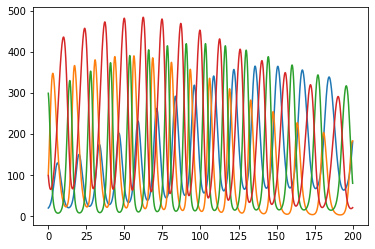

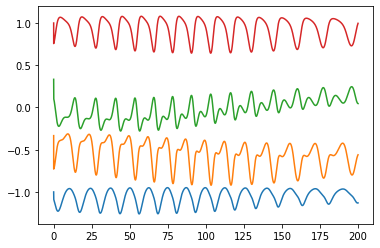

In [23]:
# Number of steps in the simulation
n_iter = 10000;
# Time step used
dt = 0.02;
# Arrays which keep track of the populations and positions over time
population_evolution = np.array([populations]);
positions_evolution = np.array([positions])
# Perform the simulation n_iter times
for i in range(1, n_iter):
    last_populations = population_evolution[-1, :]
    last_positions = positions_evolution[-1, :]
    (new_populations, new_positions) = update(last_populations, positions, predation_table, reproduction_rates, dt)
    population_evolution = np.append(population_evolution, [new_populations], axis=0)
    positions_evolution = np.append(positions_evolution, [new_positions], axis=0)

# Time intervals used for graphing
xs = [dt*x for x in range(0, n_iter)]
# Graph the populations against time
plt.plot(xs, population_evolution)
plt.show()
# Graph the positions against time
plt.plot(xs, positions_evolution)
plt.show()


We see that the behaviour this follows is periodic, which has the added perk, that if scaled properly may create a beat for the piece to follow.